##Instalación de paquetes

In [1]:
!pip install sktime
!pip install git+https://github.com/manu-mannattil/nolitsa.git
!pip install giotto-tda
!pip install scikit-learn
!pip install -U giotto-tda
!pip install ripser
!pip install kmapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-4lugn86y
  Running command git clone --filter=blob:none --quiet https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-4lugn86y
  Resolved https://github.com/manu-mannattil/nolitsa.git to commit 0e3cfd59c82c21c42da55cd24ee944b44aa0d9ad
  Preparing metadata (setup.py) ... done
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=22185 sha256=807781f1b661fc9c204065705389c67907baca5bc347c696d0564f1f17654eb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7glj6on9/wheels/0e/f4/40/d6094caec491124c7302bf2741c9d0d9897bb655c18750e12c

##Importar funciones


In [2]:
import numpy as np
import pandas as pd
import pickle
import pandas as pd
import seaborn as sns
import sklearn
from datetime import datetime
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from nolitsa import dimension, delay
import ripser
import persim
import kmapper as km
from kmapper.jupyter import display
from mpl_toolkits.mplot3d import Axes3D

##Conectar con drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Importar bases de datos de SOI Y OLR

In [4]:
SOI=pd.read_excel('/content/gdrive/MyDrive/EA2/SOI.xlsx')
SOI

,YEAR,1,2,3,4,5,6,7,8,9,10,11,12
0,1951,2.5,1.5,-0.2,-0.5,-1.1,0.3,-1.7,-0.4,-1.8,-1.6,-1.3,-1.2
1,1952,-1.5,-1.0,0.9,-0.4,1.2,1.2,0.8,0.1,-0.4,0.6,0.0,-2.0
2,1953,0.5,-0.8,-0.3,0.3,-2.8,0.2,0.0,-2.0,-2.1,0.1,-0.5,-0.8
3,1954,1.1,-0.5,0.4,1.1,0.8,0.2,0.7,1.8,0.3,0.4,0.2,2.3
4,1955,-0.9,3.1,1.1,-0.2,1.7,2.2,2.6,2.4,2.2,2.5,2.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2019,-0.1,-2.3,-0.5,0.2,-0.7,-0.7,-0.6,-0.2,-1.9,-0.6,-1.4,-0.9
69,2020,0.3,-0.1,-0.2,0.3,0.7,-0.6,0.7,1.8,1.5,0.8,1.1,3.0
70,2021,3.2,2.5,0.6,0.6,0.8,0.7,2.3,1.0,1.3,1.2,1.6,2.5
71,2022,0.8,1.8,2.9,2.8,2.4,2.8,1.3,1.7,2.7,2.8,0.5,3.5


In [5]:
SOI = pd.melt(SOI, id_vars=['YEAR'])

In [6]:
SOI.sort_values(by=['YEAR','variable'],inplace=True)
SOI = SOI.reset_index(drop=True)
SOI

,YEAR,variable,value
0,1951,1,2.5
1,1951,2,1.5
2,1951,3,-0.2
3,1951,4,-0.5
4,1951,5,-1.1
...,...,...,...
871,2023,8,-999.9
872,2023,9,-999.9
873,2023,10,-999.9
874,2023,11,-999.9


In [7]:
OLR=pd.read_excel('/content/gdrive/MyDrive/EA2/OLR.xlsx', sheet_name='Hoja1')
OLR

,YEAR,1,2,3,4,5,6,7,8,9,10,11,12
0,1974,-999.9,-999.9,-999.9,-999.9,-999.9,61.0,46.2,66.9,68.5,68.9,63.5,39.0
1,1975,32.0,52.0,54.5,48.7,64.1,59.6,64.7,72.8,74.0,73.3,67.5,67.0
2,1976,51.5,53.9,41.9,47.6,48.8,38.1,37.6,40.9,48.6,43.5,51.3,24.5
3,1977,24.4,44.4,19.4,36.6,48.9,50.1,42.8,50.0,53.7,48.5,36.5,8.0
4,1978,20.3,20.7,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
5,1979,23.4,25.4,32.7,42.5,43.3,48.9,54.0,54.1,52.5,40.8,40.4,29.0
6,1980,43.8,41.8,20.0,37.6,40.1,33.2,41.5,36.9,54.5,47.2,42.1,42.2
7,1981,40.8,24.1,22.2,23.3,50.9,49.4,47.8,64.8,53.6,54.8,51.9,34.7
8,1982,49.5,36.9,28.4,37.1,49.7,40.1,27.2,24.9,32.6,24.0,16.2,22.9
9,1983,11.3,24.7,38.0,42.7,29.7,28.9,29.9,49.0,52.1,57.3,51.0,53.9


In [8]:
OLR = pd.melt(OLR, id_vars=['YEAR'])

In [9]:
OLR.sort_values(by=['YEAR','variable'],inplace=True)
OLR = OLR.reset_index(drop=True)
OLR

,YEAR,variable,value
0,1974,1,-999.9
1,1974,2,-999.9
2,1974,3,-999.9
3,1974,4,-999.9
4,1974,5,-999.9
...,...,...,...
595,2023,8,-999.9
596,2023,9,-999.9
597,2023,10,-999.9
598,2023,11,-999.9


In [10]:
data = OLR.merge(SOI, on=['YEAR','variable'])
data.rename(columns={"YEAR":"YEAR","variable" : "MONTH","value_x": "OLR", "value_y": "SOI"},inplace = True)
data

,YEAR,MONTH,OLR,SOI
0,1974,1,-999.9,4.0
1,1974,2,-999.9,3.4
2,1974,3,-999.9,4.0
3,1974,4,-999.9,1.6
4,1974,5,-999.9,1.6
...,...,...,...,...
595,2023,8,-999.9,-999.9
596,2023,9,-999.9,-999.9
597,2023,10,-999.9,-999.9
598,2023,11,-999.9,-999.9


##Importar base de datos y mezcalr SOI y OLR

In [11]:
df=pd.read_csv('/content/gdrive/MyDrive/EA2/sstoi.indices.csv')
df

,YR M,ON N,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01


In [12]:
df = df.rename(columns={'YR M': 'YEAR', 'ON  N': 'MONTH'})
df

,YEAR,MONTH,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01


In [13]:
df = df.merge(data, on=['YEAR','MONTH'])
df

,YEAR,MONTH,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3


In [14]:
df['DAY'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-1').dt.day
df

,YEAR,MONTH,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,DAY
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0,1
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4,1
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0,1
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1,1
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5,1
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,1
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,1
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,1


In [15]:
column_name = 'DAY'
new_position = 2
column = df.pop(column_name)
df.insert(new_position, column_name, column)
df

,YEAR,MONTH,DAY,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
0,1982,1,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0
1,1982,2,1,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4
2,1982,3,1,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0
3,1982,4,1,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1
4,1982,5,1,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022,12,1,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5
492,2023,1,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3
493,2023,2,1,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3
494,2023,3,1,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3


In [16]:
# Convertir las columnas "YEAR", "MONTH" y "DAY" a una sola columna "DATE"
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])


In [17]:
# Eliminar las columnas "YEAR", "MONTH" y "DAY"
df = df.drop(['YEAR', 'MONTH', 'DAY'], axis=1)

In [18]:
column_name = 'DATE'
new_position = 0
column = df.pop(column_name)
df.insert(new_position, column_name, column)
df

,DATE,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
0,1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0
1,1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6
...,...,...,...,...,...,...,...,...,...,...,...
491,2022-12-01,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5
492,2023-01-01,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3
493,2023-02-01,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3


##Analisis de la base de datos

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     496 non-null    datetime64[ns]
 1   INO1+2   496 non-null    float64       
 2   ANOM     496 non-null    float64       
 3   NINO3    496 non-null    float64       
 4   ANOM.1   496 non-null    float64       
 5   NINO4    496 non-null    float64       
 6   ANOM NI  496 non-null    float64       
 7   NO3.4    496 non-null    float64       
 8   ANOM.2   496 non-null    float64       
 9   OLR      496 non-null    float64       
 10  SOI      496 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 46.5 KB


In [20]:
df.describe()

,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,23.238569,-0.059435,25.959617,-0.070262,28.448306,-0.103266,27.010464,-0.082903,31.042540,0.148387
std,2.325709,1.037774,1.229778,0.852488,0.678358,0.634563,0.942563,0.830024,115.423086,1.638131
min,19.060000,-1.900000,23.380000,-2.160000,26.360000,-1.870000,24.560000,-2.220000,-999.900000,-6.000000
25%,21.217500,-0.742500,24.980000,-0.652500,27.997500,-0.570000,26.337500,-0.670000,32.575000,-0.825000
50%,23.125000,-0.250000,25.930000,-0.170000,28.555000,-0.020000,27.050000,-0.115000,45.900000,0.200000
75%,25.222500,0.440000,26.872500,0.402500,28.970000,0.370000,27.682500,0.440000,56.100000,1.300000
max,28.510000,4.030000,28.810000,3.070000,30.220000,1.550000,29.540000,2.720000,74.200000,4.800000


<ipython-input-21-7b324e919061>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


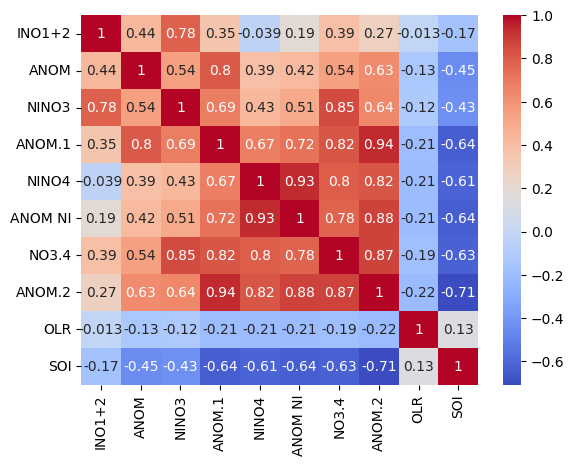

In [21]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [22]:
df.columns

Index(['DATE', 'INO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM NI',
       'NO3.4', 'ANOM.2', 'OLR', 'SOI'],
      dtype='object')

In [23]:
# Definir la ventana del promedio móvil
ventana = 3

# Calcular el promedio móvil para la columna 'valor'
df['valor_suavizado'] = df['ANOM.2'].rolling(window=ventana).mean()

# Imprimir el DataFrame original y el suavizado
print("DataFrame original:")
df

DataFrame original:


,DATE,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,valor_suavizado
0,1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0,NaN
1,1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4,NaN
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0,-0.086667
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1,-0.106667
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6,0.123333
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022-12-01,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5,-0.873333
492,2023-01-01,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,-0.820000
493,2023-02-01,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,-0.656667
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,-0.380000


In [24]:
df=df.dropna()

In [25]:
df

,DATE,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,valor_suavizado
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0,-0.086667
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1,-0.106667
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6,0.123333
5,1982-06-01,22.88,-0.29,27.10,0.46,29.46,0.62,28.35,0.65,40.1,-1.7,0.386667
6,1982-07-01,22.07,0.24,26.14,0.27,28.76,-0.02,27.57,0.27,27.2,-2.5,0.470000
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022-12-01,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5,-0.873333
492,2023-01-01,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,-0.820000
493,2023-02-01,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,-0.656667
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,-0.380000


##Takens' embedding NINO3.4 suvizado

In [26]:
max_periodic_dimension=22
max_periodic_time_delay=22
stride=1
tau,d= takens_embedding_optimal_parameters(df["valor_suavizado"], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  14 
Optimal dimension:  9


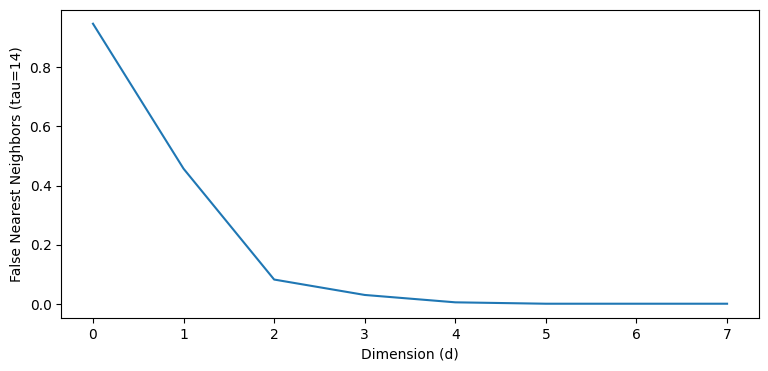

In [27]:
dim = np.arange(1, 9)
f1, f2, f3 = dimension.fnn(df["valor_suavizado"], tau=14, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=14)')
plt.plot(f1)

##PCA  Análisis de Componentes Principales

PCA valor de la anomalia ANOM2 suaviazada

In [28]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(df["valor_suavizado"])


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (382, 9)


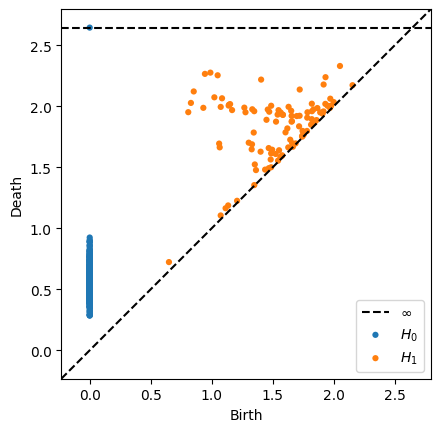

In [29]:
ripsprueba=ripser.ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(ripsprueba,show=True)

PCA valor de la anomalia ANOM2

In [30]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(df["ANOM.2"])


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (399, 6)


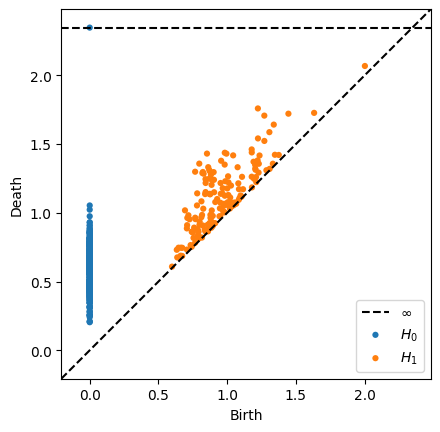

In [31]:
ripsprueba=ripser.ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(ripsprueba,show=True)

##

In [32]:
df

,DATE,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,valor_suavizado
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0,-0.086667
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1,-0.106667
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6,0.123333
5,1982-06-01,22.88,-0.29,27.10,0.46,29.46,0.62,28.35,0.65,40.1,-1.7,0.386667
6,1982-07-01,22.07,0.24,26.14,0.27,28.76,-0.02,27.57,0.27,27.2,-2.5,0.470000
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022-12-01,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5,-0.873333
492,2023-01-01,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,-0.820000
493,2023-02-01,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,-0.656667
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,-0.380000


##Mapper


In [33]:
data1 = df[['valor_suavizado','NO3.4']].to_numpy()

In [34]:
data1[8, :]

array([ 1.55, 28.5 ])

In [35]:
data1[9, :]

array([ 1.87333333, 28.85      ])

In [36]:
data1[10, :]

array([ 2.00666667, 28.7       ])

In [37]:
mapper1 = km.KeplerMapper(verbose=1)
# La proyección sobre en las variables Anom.2 y NO3.4
projected_data1 = mapper1.fit_transform(data1, projection=[0,1] )
covering=km.Cover(n_cubes=3,perc_overlap=0.3)
G1 = mapper1.map(projected_data1, data1, clusterer=sklearn.cluster.KMeans(n_clusters=3),cover=covering)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (494, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (494, 2) using lens shaped (494, 2)

Creating 9 hypercubes.

Created 53 edges and 24 nodes in 0:00:00.159619.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [38]:
mapper1.visualize(G1,
                title='Performance Data based on Anom.2 and Niño3.4',
                color_values = df["valor_suavizado"],
                color_function_name = 'La suavizada',
                node_color_function=np.array(['average','std','sum','max','min']))


km.jupyter.display("Niño3.4" + ".html")

Wrote visualization to: mapper_visualization_output.html


/usr/local/lib/python3.10/dist-packages/kmapper/visuals.py:344: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/kmapper/visuals.py:345: RuntimeWarning:

invalid value encountered in long_scalars



/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning:

Consider using IPython.display.IFrame instead



In [39]:
df1[4, :]

NameError: ignored

##Serie Partida

In [40]:
df_dividido = np.array_split(df, len(df) // 120)

# Mostrar cada parte por separado
for i, parte in enumerate(df_dividido):
    print(f"Parte {i + 1}:")
    print(parte)
    print()

Parte 1:
          DATE  INO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM NI  NO3.4  ANOM.2  \
2   1982-03-01   25.22 -1.38  26.92   -0.25  28.18    -0.05  27.09   -0.14   
3   1982-04-01   24.57 -1.16  27.52   -0.05  28.61     0.10  27.83    0.02   
4   1982-05-01   24.00 -0.62  27.70    0.49  29.19     0.40  28.37    0.49   
5   1982-06-01   22.88 -0.29  27.10    0.46  29.46     0.62  28.35    0.65   
6   1982-07-01   22.07  0.24  26.14    0.27  28.76    -0.02  27.57    0.27   
..         ...     ...   ...    ...     ...    ...      ...    ...     ...   
121 1992-02-01   26.25  0.15  27.34    0.96  28.76     0.67  28.28    1.55   
122 1992-03-01   27.38  0.78  27.87    0.71  28.83     0.60  28.39    1.16   
123 1992-04-01   27.17  1.44  28.46    0.89  29.03     0.52  28.81    1.00   
124 1992-05-01   26.09  1.47  28.28    1.07  29.12     0.33  28.79    0.91   
125 1992-06-01   23.66  0.48  27.12    0.47  29.01     0.17  28.12    0.42   

      OLR  SOI  valor_suavizado  
2    28.4  1.0      

In [41]:
df_1=parte
df_1

,DATE,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,valor_suavizado
373,2013-02-01,25.98,-0.11,25.83,-0.55,28.19,0.09,26.25,-0.48,36.6,-0.4,-0.476667
374,2013-03-01,26.11,-0.49,27.20,0.04,27.74,-0.49,27.02,-0.22,33.4,2.5,-0.393333
375,2013-04-01,24.65,-1.08,27.59,0.02,28.36,-0.15,27.92,0.11,47.1,0.4,-0.196667
376,2013-05-01,23.24,-1.37,26.52,-0.69,28.57,-0.22,27.58,-0.30,52.3,1.3,-0.136667
377,2013-06-01,21.27,-1.90,25.84,-0.80,28.57,-0.27,27.37,-0.34,49.2,2.0,-0.176667
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022-12-01,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5,-0.873333
492,2023-01-01,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,-0.820000
493,2023-02-01,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,-0.656667
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,-0.380000


In [42]:
max_periodic_dimension=11
max_periodic_time_delay=11
stride=1
tau,d= takens_embedding_optimal_parameters(df_1["valor_suavizado"], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  5 
Optimal dimension:  7


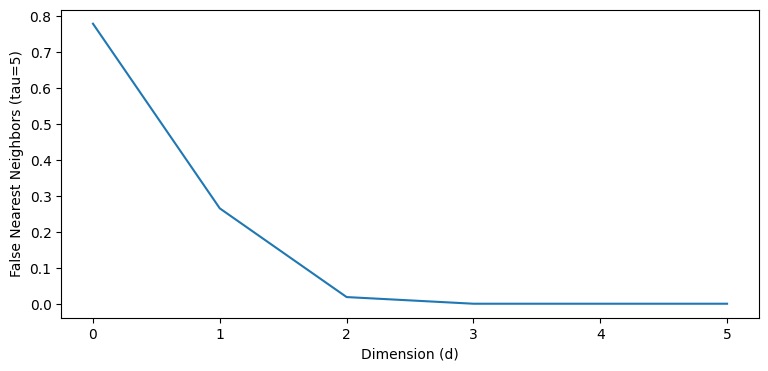

In [43]:
dim = np.arange(1, 7)
f1, f2, f3 = dimension.fnn(df_1["ANOM.2"], tau=5, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=5)')
plt.plot(f1)

In [44]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(df_1["valor_suavizado"])


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (93, 7)


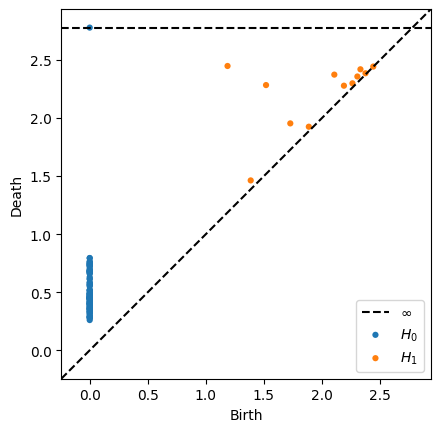

In [45]:
ripsprueba=ripser.ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(ripsprueba,show=True)

In [46]:
data2 = df_1[['valor_suavizado','NO3.4']].to_numpy()

In [47]:
mapper1 = km.KeplerMapper(verbose=1)
# La proyección sobre en las variables Anom.2 y NO3.4
projected_data1 = mapper1.fit_transform(data2, projection=[0,1] )
covering=km.Cover(n_cubes=3,perc_overlap=0.3)
G1 = mapper1.map(projected_data1, data2, clusterer=sklearn.cluster.KMeans(n_clusters=3),cover=covering)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (123, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (123, 2) using lens shaped (123, 2)

Creating 9 hypercubes.

Created 27 edges and 21 nodes in 0:00:00.148874.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [48]:
mapper1.visualize(G1,
                title='Performance Data based on Anom.2 and Niño3.4',
                color_values = df_1["valor_suavizado"],
                color_function_name = 'La suavizada',
                node_color_function=np.array(['average','std','sum','max','min']))


km.jupyter.display("Niño3.4" + ".html")

Wrote visualization to: mapper_visualization_output.html


/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning:

Consider using IPython.display.IFrame instead



In [49]:
data2[26, :]

array([ 0.67, 28.63])

In [50]:
data2[27, :]

array([ 0.69666667, 28.71      ])

In [51]:
data2[28, :]

array([ 0.89, 28.73])

In [52]:
import gtda.time_series as gts
import gtda.diagrams as gtd
# Convertir las columnas "fecha" y "niño3.4" en un array NumPy
fecha_array = np.array(df["valor_suavizado"])
niño34_array = np.array(df["ANOM.2"])

# Apilar las columnas en una matriz bidimensional
data = np.column_stack((fecha_array, niño34_array))

from gtda.plotting import plot_point_cloud

plot_point_cloud(data)